In [0]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx

All data

In [0]:
# Load data
Name_sector = pd.read_csv('finance_data/Name_sector.csv')
Name_sector['Symbol']

In [0]:
stocks = os.listdir('finance_data/data/')
len(stocks)

505

In [0]:
# Delete stocks with <764 days
count = 0
for stock in stocks:
    cur_stock = pd.read_csv('finance_data/data/'+stock)
    if (len(cur_stock['Date']) != 765):
        count += 1
        stocks.remove(stock)

In [0]:
len(stocks)

494

In [0]:
# Get return dictionary (log normalized)
return_dict_log = {}
stock_name_list = []

for stock in stocks:
    stock_name = stock.split('.csv')[0]
    stock_name_list.append(stock_name)
    cur_stock = pd.read_csv('finance_data/data/'+stock)
    pi = cur_stock['Close']

    # Calculate qi, ri
    qi = []
    ri = []
    for t in range(1, len(pi)):
        qi_t = (pi[t]-pi[t-1])/pi[t-1]
        ri_t = math.log(1+qi_t)
        qi.append(qi_t)
        ri.append(ri_t)

    return_dict_log[str(stock_name)] = ri

In [0]:
# Get correlation
def get_correlation(stock_i, stock_j, return_dict):
    return_i = np.array(return_dict[stock_i])
    return_j = np.array(return_dict[stock_j])
    
    avg_1 = np.mean(np.multiply(return_i, return_j))
    avg_2 = np.mean(return_i) * np.mean(return_j)
    deno_1 = np.mean(return_i**2)-np.mean(return_i)**2
    deno_2 = np.mean(return_j**2)-np.mean(return_j)**2
    corr = (avg_1 - avg_2)/np.sqrt(deno_1 * deno_2)
    
    return corr

In [0]:
# Get correlation matrix
corr_matrix = np.zeros((len(stock_name_list),len(stock_name_list)))
for i in range(len(stock_name_list)):
    for j in range(len(stock_name_list)):
        stock_i = stock_name_list[i]
        stock_j = stock_name_list[j]
        corr = get_correlation(stock_i, stock_j, return_dict_log)
        # print(corr)
        corr_matrix[i][j] = corr

In [0]:
print(corr_matrix.shape)

(494, 494)


In [0]:
# Q1
print("max: ",np.max(corr_matrix))
print("min: ",np.min(corr_matrix))

max:  1.0
min:  -0.1985733513184204


In [0]:
# Q2
# Compute edge weights
weight_matrix = np.sqrt(2 * (1 - corr_matrix))
weight_list = []

weight_file = open("weight.txt", "w")
for i in range(len(stock_name_list)):
    for j in range(i+1, len(stock_name_list)):
        weight_file.write('{} {} {}\n'.format(stock_name_list[i], stock_name_list[j], weight_matrix[i][j]))
        weight_list.append(weight_matrix[i][j])

weight_file.close()

(array([2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 1.4000e+01, 2.5000e+01, 3.0000e+01, 4.3000e+01,
        4.8000e+01, 7.3000e+01, 1.0700e+02, 1.1300e+02, 1.2800e+02,
        1.6400e+02, 1.4600e+02, 2.0000e+02, 2.0700e+02, 2.8900e+02,
        3.4200e+02, 4.5900e+02, 7.4500e+02, 1.1860e+03, 1.8560e+03,
        2.6770e+03, 3.8280e+03, 5.3580e+03, 6.8360e+03, 8.1980e+03,
        9.6200e+03, 1.0987e+04, 1.1832e+04, 1.1937e+04, 1.1461e+04,
        1.0081e+04, 8.6840e+03, 6.7310e+03, 4.4880e+03, 2.0470e+03,
        5.6100e+02, 1.9800e+02, 4.8000e+01, 1.0000e+01, 7.0000e+00]),
 array([0.15215947, 0.18008172, 0.20800397, 0.23592623, 0.26384848,
        0.29177074, 0.31969299, 0.34761524, 0.3755375 , 0.40345975,
        0.43138201, 0.45930426, 0.48722651, 0.51514877, 0.54307102,
        0.57099328, 0.59891553, 0.62683778, 0.65476004, 0.68268229,
        0.71060455, 0.7385268 , 0.76644905, 0.

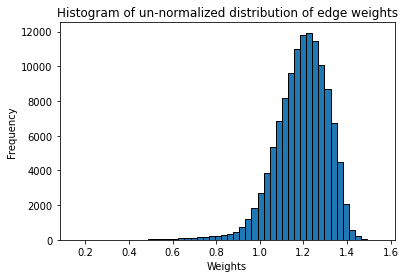

In [0]:
plt.title('Histogram of un-normalized distribution of edge weights')
plt.xlabel('Weights')
plt.ylabel('Frequency')
plt.hist(weight_list, bins=50, edgecolor = 'black')

In [0]:
!pip install python-igraph

     |████████████████████████████████| 3.2MB 9.6MB/s 


In [0]:
import igraph
from igraph import *

In [0]:
# Construct the correlation graph
stock_graph = Graph()
stock_graph.add_vertices(stock_name_list)

for i in range(len(stock_name_list)):
    for j in range(i+1, len(stock_name_list)):
         stock_i = stock_name_list[i]
         stock_j = stock_name_list[j]
         stock_graph.add_edge(stock_i, stock_j, weight = weight_matrix[i][j])

In [0]:
stock_graph.ecount()

121771

Weekly data

In [0]:
# Get return dictionary (log normalized)
return_dict_log_weekly = {}
stock_name_list = []

for stock in stocks:
    stock_name = stock.split('.csv')[0]
    stock_name_list.append(stock_name)
    cur_stock = pd.read_csv('finance_data/data/'+stock)
    cur_stock['Weekday'] = pd.to_datetime(cur_stock['Date']).apply(lambda x: x.weekday())
    cur_stock = cur_stock[cur_stock['Weekday'] == 0]
    pi = list(cur_stock['Close'])

    # Calculate qi, ri
    qi = []
    ri = []
    for t in range(1, len(pi)):
        qi_t = (pi[t]-pi[t-1])/pi[t-1]
        ri_t = math.log(1+qi_t)
        qi.append(qi_t)
        ri.append(ri_t)

    return_dict_log_weekly[str(stock_name)] = ri

In [0]:
# Get correlation matrix
corr_matrix_weekly = np.zeros((len(stock_name_list),len(stock_name_list)))
for i in range(len(stock_name_list)):
    for j in range(len(stock_name_list)):
        stock_i = stock_name_list[i]
        stock_j = stock_name_list[j]
        corr = get_correlation(stock_i, stock_j, return_dict_log_weekly)
        # print(corr)
        corr_matrix_weekly[i][j] = corr

In [0]:
print(corr_matrix_weekly.shape)

(494, 494)


In [0]:
# Compute edge weights
weight_matrix_weekly = np.sqrt(2 * (1 - corr_matrix_weekly))
weight_list_weekly = []

weight_file_weekly = open("weight_weekly.txt", "w")
for i in range(len(stock_name_list)):
    for j in range(i+1, len(stock_name_list)):
        weight_file_weekly.write('{} {} {}\n'.format(stock_name_list[i], stock_name_list[j], weight_matrix_weekly[i][j]))
        weight_list_weekly.append(weight_matrix_weekly[i][j])

weight_file_weekly.close()